<h2>Введение</h2>

В ходе работы проведен анализ спроса шеринговых услуг на самокаты. Ссылка на презентацию: https://docs.google.com/presentation/d/1dfgImWX1KYx5DyX2x0NohfhMnadwP_cBPGLWlhjXfsM/edit?usp=sharing.

Импортируем библиотеки испоьзуемые при анализе

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

<h2>Загрузка данных</h2>

<i>используем датасеты из папки files</i>

In [2]:
data_rides= pd.read_csv("files/rides.csv", sep=",")
data_weather = pd.read_csv("files/weather.csv", sep=",")

<h2>Исследование данных на качество</h2>

<h4>1. Верно ли, что в дождливое время спрос на самокаты ниже?</h4>

<h3>Анализ датасета <i>rides.csv</i></h3>

In [3]:
data_rides.head(5)

,Id,Start Date,End Date,Start Location,Start District,End Location,End District,Distance,Promo
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069.0,0
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,заречный,Спортивная,октябрьский,4515.0,0
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,ленинский,4520.0,0
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881.0,0
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029.0,0


<h4>1) Приведение названий столбцов к pep-8 формату.</h4>

In [4]:
for i in data_rides.columns:
    data_rides = data_rides.rename(columns={i: i.lower().replace(" ", "_")})

<h4>2) Исследование типов данных, приведение к правильному типу</h4>

In [5]:
data_rides["start_date"] = pd.to_datetime(data_rides["start_date"]) 
data_rides["end_date"] = pd.to_datetime(data_rides["end_date"]) 
data_rides = data_rides.astype({"distance" : float, "promo": bool})

<h4>3) Проверка на явные и неявные дубликаты. Обработка дубликатов. </h4>

<i>Для избежания ошибок агрегации изменим регистр всех названий </i>

In [6]:
data_rides["start_location"] = data_rides["start_location"].str.lower()
data_rides["end_location"] = data_rides["end_location"].str.lower()
data_rides["start_district"] = data_rides["start_district"].str.lower()
data_rides["end_district"] = data_rides["end_district"].str.lower()

<i>Также перед названием улиц могут встречаться: ул., ул. Для учета этого удалим такие обозначения, оставив только названия. </i>

In [7]:
import re

def cl_street_name(street_name):
    cleaned_name = re.sub(r'^s*ул. ?s*', '', street_name)
    return cleaned_name

    

In [8]:
# Неявные дубликаты в категориальных столбцах

data_rides["end_location"] = data_rides["end_location"].apply(cl_street_name)
data_rides["start_location"] = data_rides["start_location"].apply(cl_street_name)


In [9]:
#явные дубликаты
data_rides = data_rides.drop_duplicates()

In [10]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97372 entries, 0 to 102254
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              97372 non-null  int64         
 1   start_date      97372 non-null  datetime64[ns]
 2   end_date        96817 non-null  datetime64[ns]
 3   start_location  97372 non-null  object        
 4   start_district  97372 non-null  object        
 5   end_location    97372 non-null  object        
 6   end_district    97372 non-null  object        
 7   distance        96191 non-null  float64       
 8   promo           97372 non-null  bool          
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 6.8+ MB


<h4>4) Проверка данных на выбросы и адекватность значений.</h4>

In [11]:
Q1 = data_rides["distance"].quantile(0.25)
Q3 = data_rides["distance"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data_rides[(data_rides["distance"] < lower_bound) | (data_rides["distance"] > upper_bound)]
print(f"Количество выбросов: {outliers.shape[0]}")

Количество выбросов: 4700


<i>Причина выбросов может быть связана с неправильным считыванием начала и конца поездки из-за проблем, вызванных счетчиком пробега.</i>

In [12]:
# Замена выбросов на медиану
median_distance = data_rides["distance"].median()
data_rides.loc[data_rides["distance"] < lower_bound, "distance"] = median_distance
data_rides.loc[data_rides["distance"] > upper_bound, "distance"] = median_distance

<h4>5) Проверка на пропуски и заполнение</h4>

In [13]:
print(f"Пропуски в данных:\n{data_rides.isnull().sum()}")




Пропуски в данных:
id                   0
start_date           0
end_date           555
start_location       0
start_district       0
end_location         0
end_district         0
distance          1181
promo                0
dtype: int64


In [14]:
data_rides["distance"].fillna(median_distance, inplace=True)
data_rides["end_date"].interpolate(method="linear", inplace=True)
print(f"Пропуски в данных:\n{data_rides.isnull().sum()}")




Пропуски в данных:
id                0
start_date        0
end_date          0
start_location    0
start_district    0
end_location      0
end_district      0
distance          0
promo             0
dtype: int64


                  id                     start_date  \
count   97372.000000                          97372   
mean   149025.500000  2023-06-13 21:06:08.931407360   
min    100340.000000            2023-04-22 09:01:03   
25%    124682.750000     2023-05-20 21:41:39.500000   
50%    149025.500000            2023-06-14 15:15:46   
75%    173368.250000  2023-07-08 19:50:22.249999872   
max    197711.000000            2023-07-31 23:57:01   
std     28109.019543                            NaN   

                            end_date      distance  
count                          97372  97372.000000  
mean   2023-06-13 21:32:31.608326912   3776.441164  
min              2023-04-22 09:24:45    969.000000  
25%    2023-05-20 22:07:33.750000128   3145.000000  
50%              2023-06-14 15:44:53   3703.000000  
75%              2023-07-08 20:18:30   4355.000000  
max              2023-08-01 00:42:12   6507.000000  
std                              NaN    928.187932  


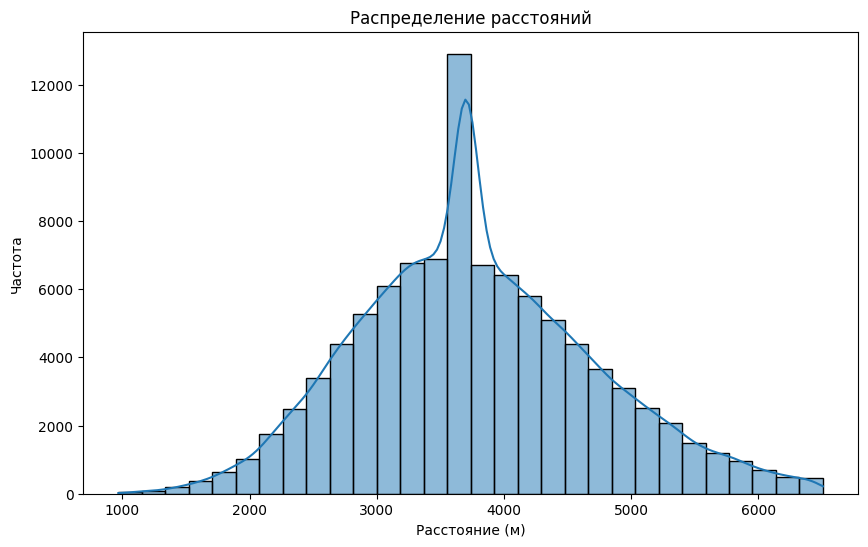

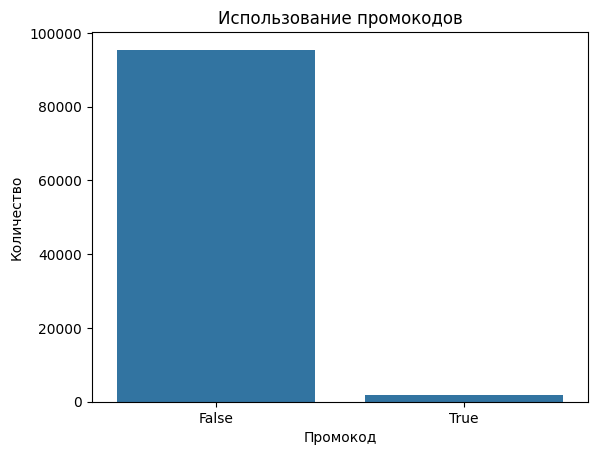

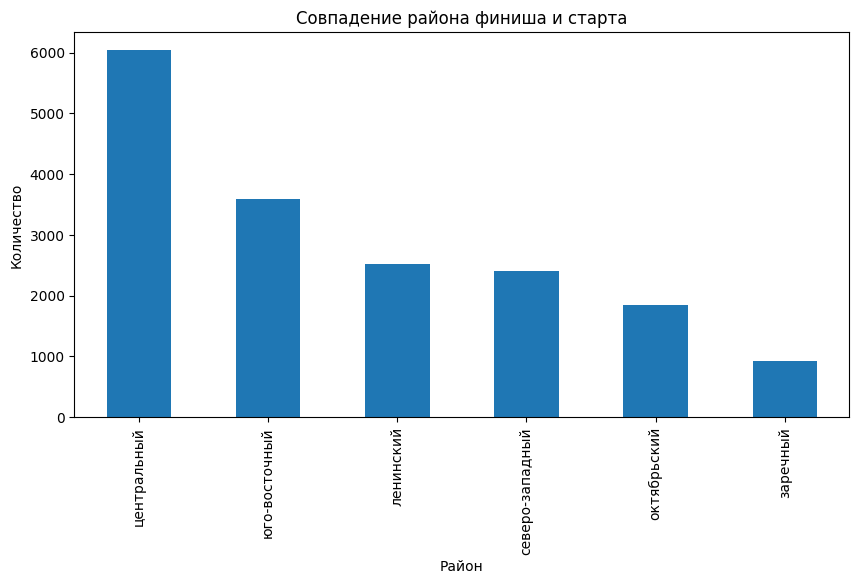

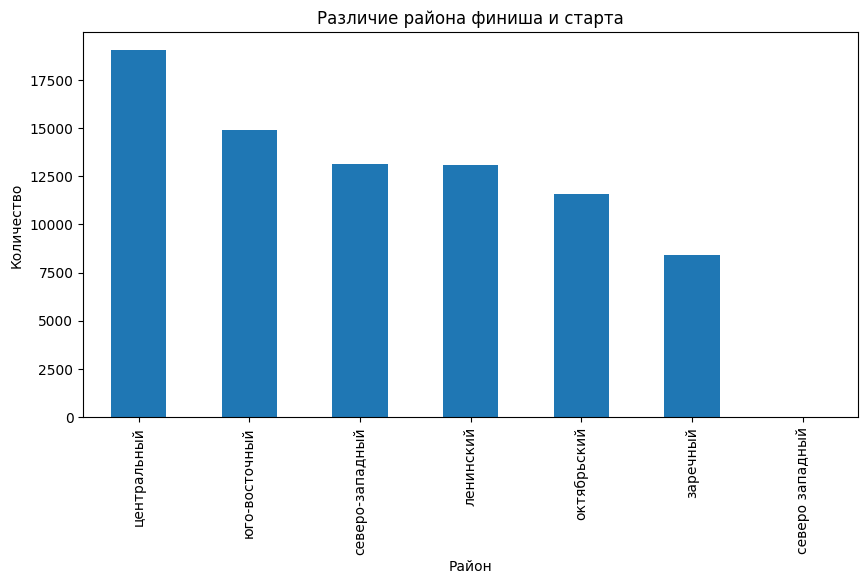

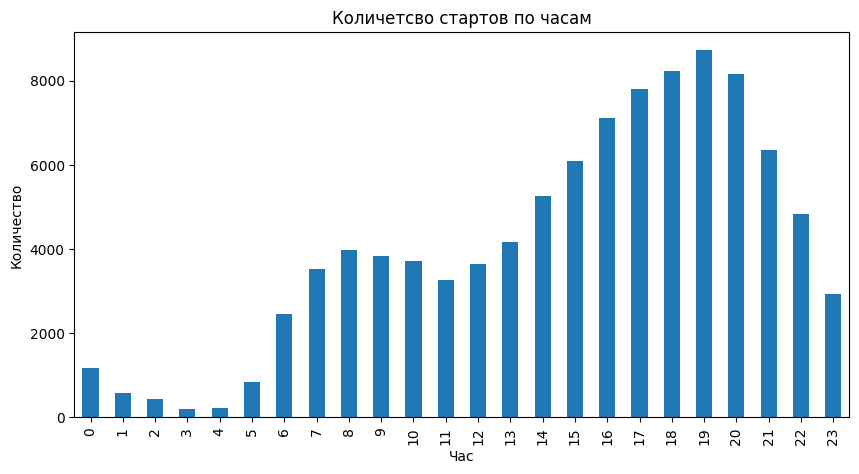

In [15]:
# Описание статистических характеристик
print(data_rides.describe())

# График распределения расстояний
plt.figure(figsize=(10, 6))
sns.histplot(data_rides["distance"], bins=30, kde=True)
plt.title("Распределение расстояний")
plt.xlabel("Расстояние (м)")
plt.ylabel("Частота")
plt.show()

# Анализ промокодов
promo_counts = data_rides["promo"].value_counts()
sns.barplot(x=promo_counts.index, y=promo_counts.values)
plt.title("Использование промокодов")
plt.xlabel("Промокод")
plt.ylabel("Количество")
plt.show()


#Частота совпадение района финиша и старта
same_district_trips = data_rides[data_rides["start_district"] == data_rides["end_district"]]
district_trips_count = same_district_trips["start_district"].value_counts()
district_trips_count.plot(kind="bar", figsize=(10, 5))
plt.xlabel("Район")
plt.ylabel("Количество")
plt.title("Совпадение района финиша и старта")
plt.xticks(rotation=90)
plt.show()

#Частота различие района финиша и старта
same_district_trips = data_rides[data_rides["start_district"] != data_rides["end_district"]]
district_trips_count = same_district_trips["start_district"].value_counts()
district_trips_count.plot(kind="bar", figsize=(10, 5))
plt.xlabel("Район")
plt.ylabel("Количество")
plt.title("Различие района финиша и старта")
plt.xticks(rotation=90)
plt.show()


#Количетсво стартов по часам
data_rides["start_hour"] = data_rides["start_date"].dt.hour
hourly_trips = data_rides.groupby("start_hour")["id"].count()
hourly_trips.plot(kind="bar", figsize=(10, 5))
plt.xlabel("Час")
plt.ylabel("Количество")
plt.title("Количетсво стартов по часам")
plt.xticks(range(0, 24))
plt.show()


<H5>Выводы:</H5>

* Распределение дистанции нормальное 
* Большее количество стартов происходит без промокода
* Большинство поездок начинается и заканчивается в разных районах 
* Большинство поездок начинается во второй половине дня

<h3>Анализ датасета <i>weather.csv</i></h3>

In [16]:
data_weather.head(5)

,Datetime,Temperature,Precipitation Total,Wind Gust,Wind Speed,Cloud Cover Total,Sunshine Duration
0,NaN,°C,mm,km/h,km/h,%,min
1,2023-04-01T00:00:00,8.740245,0.1,48.6,21.638964,90,0
2,2023-04-01T01:00:00,9.040245,0.2,55.44,22.493519,74,0
3,2023-04-01T02:00:00,8.880245,0.3,55.8,22.26477,72,0
4,2023-04-01T03:00:00,8.690246,0.3,55.44,21.94524,77,0


<h4>1) Приведение названий столбцов к pep-8 формату.</h4>

In [17]:
data_weather = data_weather[1:]
for i in data_weather.columns:
    data_weather = data_weather.rename(columns={i: i.lower().replace(" ", "_")})

<h4>2) Исследование типов данных, приведение к правильному типу</h4>

In [18]:
data_weather = data_weather.astype({"temperature" : float,
           "precipitation_total": float, "wind_gust": float, 
           "wind_speed": float, "cloud_cover_total": float, "sunshine_duration": float})
data_weather["datetime"] = pd.to_datetime(data_weather["datetime"])

<h4>3) Проверка на явные дубликаты. Обработка дубликатов. </h4>

In [19]:
duplicate_count = data_weather.duplicated().sum()

print(f"Количество дубликатов: {duplicate_count}")

Количество дубликатов: 0


<h4>4) Проверка данных на выбросы и адекватность значений.</h4>

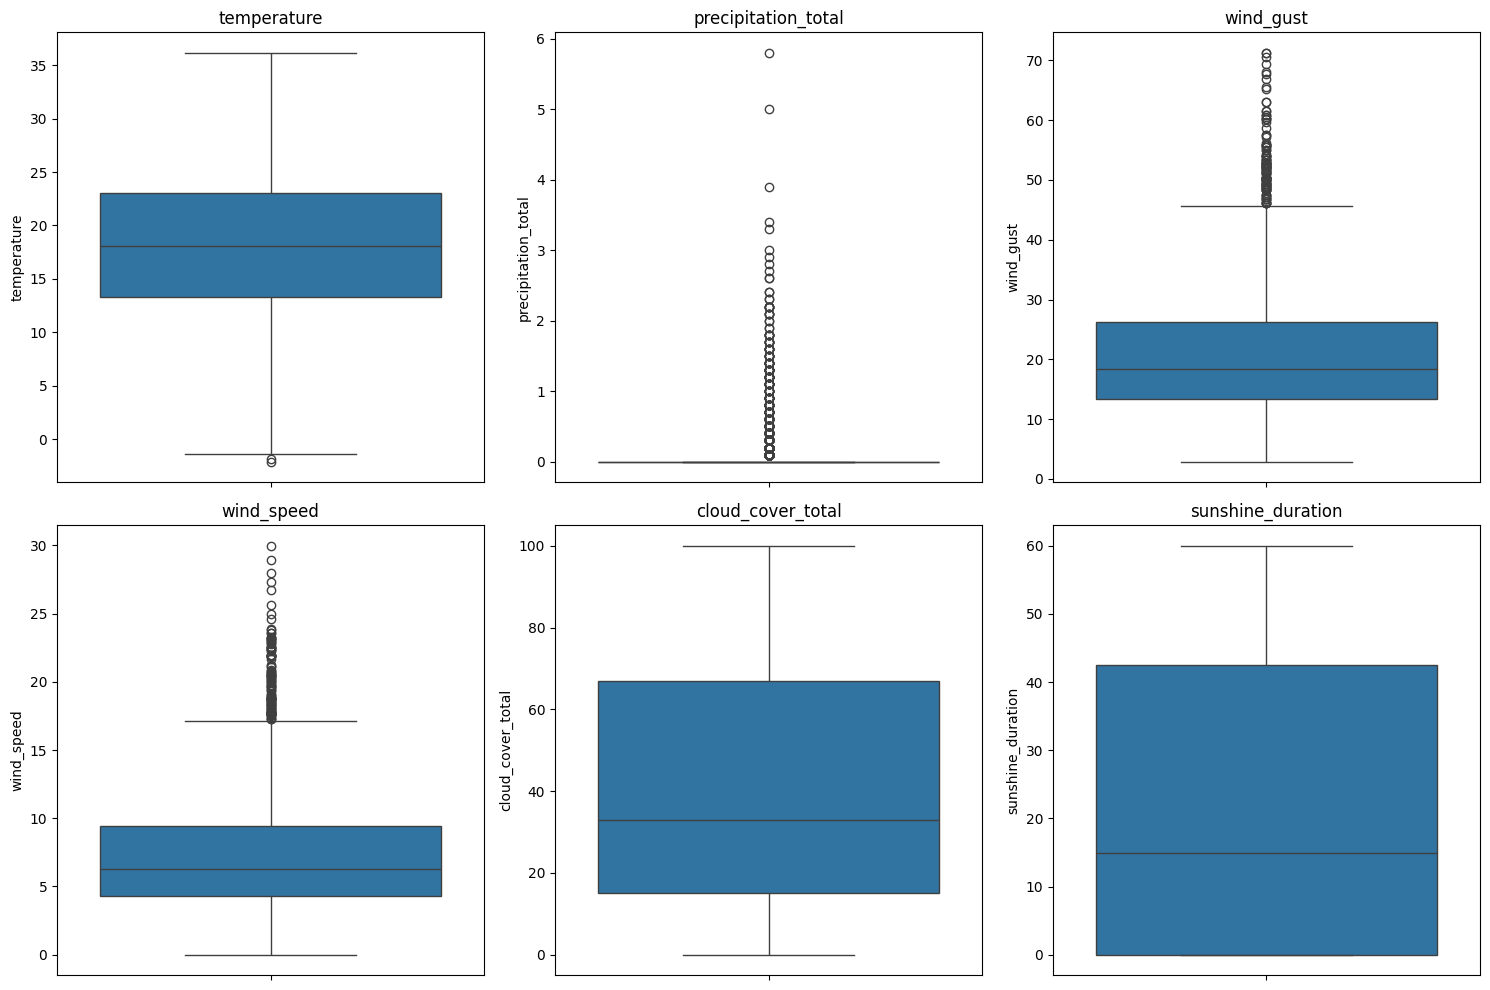

In [20]:
nm_columns = ["temperature", "precipitation_total", "wind_gust",
       "wind_speed", "cloud_cover_total", "sunshine_duration"]
plt.figure(figsize=(15, 10))
for i, col in enumerate(nm_columns):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=data_weather[col])
    plt.title(col)

plt.tight_layout()
plt.show()

<i>Выбросы в столбцах wind_speed и wind_gust могут быть связаны с штормами или другими погодными катаклизмами. Любые осадки precipitation_total могут восприниматься как необычное явление, поэтому на графике они отмечены как выбросы. Выбросы, связанные с отрицательной температурой, связаны со сменой сезона и концом самокатного сезона. </i>

<h4>5) Проверка на пропуски и заполнение</h4>

In [21]:
print(data_weather.isnull().sum())

datetime                0
temperature            55
precipitation_total    30
wind_gust               0
wind_speed             16
cloud_cover_total      20
sunshine_duration      12
dtype: int64


<i>Заполним пропуски интерполяцией</i>

In [22]:
data_weather.interpolate(method="linear", inplace=True)
data_weather.fillna(data_weather.median(), inplace=True)

<h4>6) Аналитический и графический анализ данных.</h4> 

                            datetime  temperature  precipitation_total  \
count                           3672  3672.000000          3672.000000   
mean   2023-06-16 11:30:00.000000256    18.083915             0.100218   
min              2023-04-01 00:00:00    -2.079755             0.000000   
25%              2023-05-09 05:45:00    13.220245             0.000000   
50%              2023-06-16 11:30:00    18.010244             0.000000   
75%              2023-07-24 17:15:00    22.952745             0.000000   
max              2023-08-31 23:00:00    36.150246             5.800000   
std                              NaN     6.837505             0.342384   

         wind_gust   wind_speed  cloud_cover_total  sunshine_duration  
count  3672.000000  3672.000000        3672.000000        3672.000000  
mean     20.886568     7.351731          40.980882          21.541568  
min       2.880000     0.000000           0.000000           0.000000  
25%      13.320000     4.334974          15.0

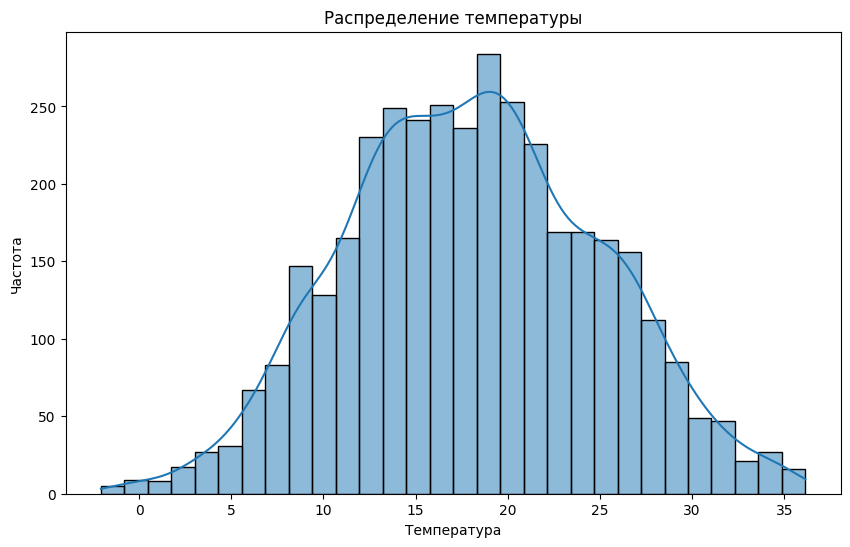

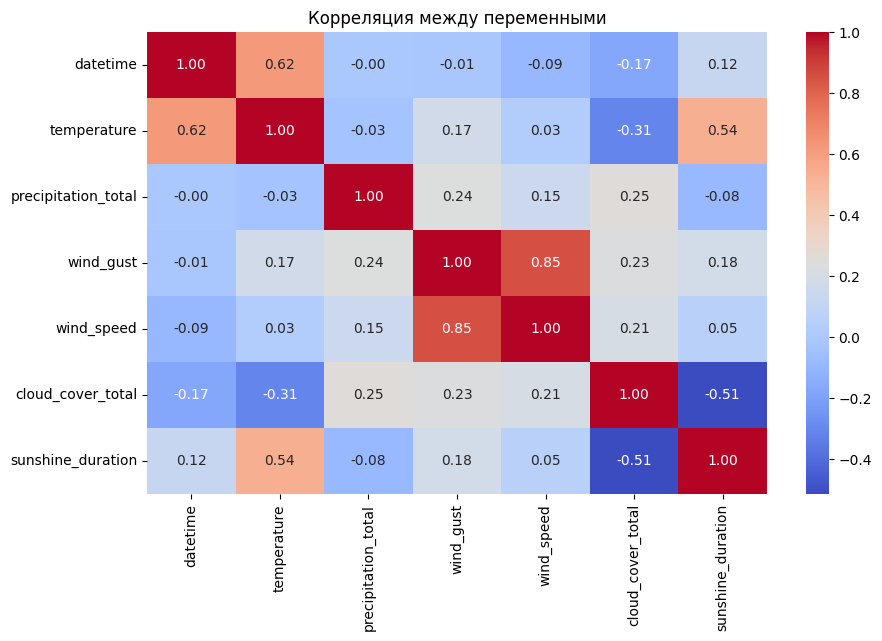

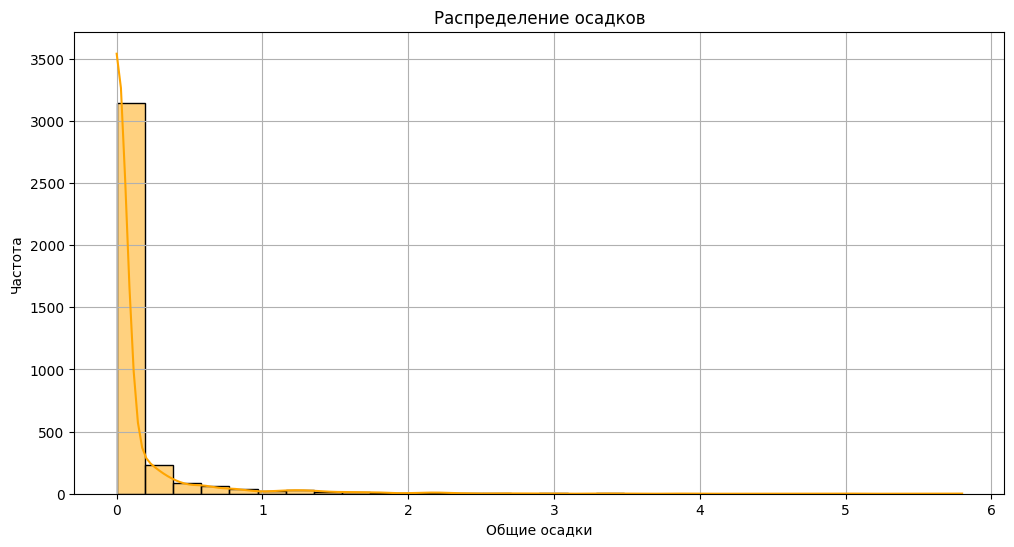

In [23]:
# Описание статистических характеристик
print(data_weather.describe())

# Визуализация распределения температуры
plt.figure(figsize=(10, 6))
sns.histplot(data_weather["temperature"], bins=30, kde=True)
plt.title("Распределение температуры")
plt.xlabel("Температура")
plt.ylabel("Частота")
plt.show()

# Корреляция между переменными
plt.figure(figsize=(10, 6))
sns.heatmap(data_weather.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляция между переменными")
plt.show()

# Гистограмма осадков
plt.figure(figsize=(12, 6))
sns.histplot(data_weather["precipitation_total"], bins=30, kde=True, color="orange")
plt.title("Распределение осадков")
plt.xlabel("Общие осадки")
plt.ylabel("Частота")
plt.grid()
plt.show()

<H5>Выводы:</H5>

* Распределение температуры нормальное 
* Большое количество дней осадки отстутвуют 

<h3>Объединение датасетов <i>data_rides</i> и <i>data_weather</i></h3>

In [24]:
data_weather = data_weather.sort_values("datetime")
df_merged = pd.merge_asof(data_rides, data_weather, left_on="start_date", right_on="datetime", direction="backward")
df_merged.head(3)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,start_hour,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696


<i>Датасеты объединены по погоде при старте поездки</i>

Сохраняем и смотрим на результат

In [25]:
df_merged.to_csv("sharing.csv", index=False)
df_merged.head(5)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,start_hour,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696


<h2>Проведение расчетов и исследований</h2>

<h4> 1) Рассчет итоговой стоимости </h4>

In [26]:
#длительность поездок
df_merged["duration"] = (df_merged["end_date"] - df_merged["start_date"]).dt.total_seconds() / 60

In [27]:
#функция расчета стоимости
def calculate_fare(start_time, duration, promo):
    day_of_week = start_time.weekday()
    hour = start_time.hour

    if hour >= 1 and hour < 6:
        cost_per_minute = 3
    elif hour > 6 and hour < 10:
        cost_per_minute = 4
    elif hour >= 10 and hour < 16:
        cost_per_minute = 5 if day_of_week < 4 else 6
    elif hour >= 16 and hour < 22:
        cost_per_minute = 6 if day_of_week < 4 else 7
    else:
        cost_per_minute = 5 if day_of_week < 4 else 6

    if day_of_week == 0 and hour >= 6 and hour < 10 and promo is True:
        start_cost = 0
    else:
        start_cost = 30

    fare = start_cost + duration * cost_per_minute

    return fare

In [28]:
df_merged["fare"] = df_merged.apply(lambda row: calculate_fare(row["start_date"], row["duration"], row["promo"]), axis=1)
df_merged.head(5)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,start_hour,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration,duration,fare
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,23.700000,124.800000
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,28.416667,143.666667
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,38.316667,183.266667
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,31.816667,157.266667
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,30.666667,152.666667


In [29]:
df_merged["fare"].describe()

count    97372.000000
mean       182.471045
std         66.944630
min         22.133333
25%        135.900000
50%        171.200000
75%        216.000000
max        623.366667
Name: fare, dtype: float64

<h4>2) Проверка, стимулирует ли акция спрос на самокат</h4> 

<i>Сравнение дней недели по времени проведения акции в понедельник</i>

<i> С 6 до 10 </i>

In [30]:
#измерение поездок по дням недели
num_of_trips = []
days_of_week = ["Понедельник", "Вторник", "Среда", "четверг", "Пятница", "Суббота", "Воскресенье"]
promo_days = df_merged[(df_merged["start_date"].dt.weekday == 0) & (df_merged["start_date"].dt.hour >= 6) & (df_merged["start_date"].dt.hour < 10)]
num_of_trips.append(promo_days.shape[0])
for i in range(1,7):
    non = df_merged[(df_merged["start_date"].dt.weekday == i) & (df_merged["start_date"].dt.hour >= 6) & (df_merged["start_date"].dt.hour < 10)]
    num_of_trips.append(non.shape[0])


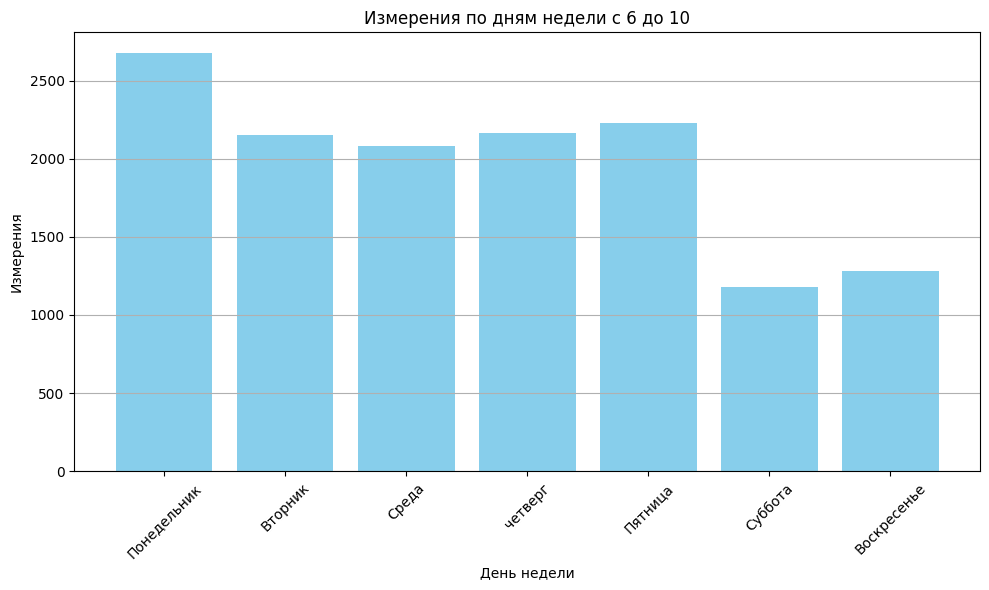

In [31]:
plt.figure(figsize=(10, 6))
plt.bar(days_of_week, num_of_trips, color="skyblue")
plt.title("Измерения по дням недели с 6 до 10")
plt.xlabel("День недели")
plt.ylabel("Измерения")
plt.xticks(rotation=45)
plt.grid(axis="y")

plt.tight_layout()
plt.show()

<i> С 10 до 14 </i>

In [32]:
#измерение поездок по дням недели
num_of_trips = []
days_of_week = ["Понедельник", "Вторник", "Среда", "четверг", "Пятница", "Суббота", "Воскресенье"]
promo_days = df_merged[(df_merged["start_date"].dt.weekday == 0) & (df_merged["start_date"].dt.hour >= 10) & (df_merged["start_date"].dt.hour < 14)]
num_of_trips.append(promo_days.shape[0])
for i in range(1,7):
    non = df_merged[(df_merged["start_date"].dt.weekday == i) & (df_merged["start_date"].dt.hour >= 10) & (df_merged["start_date"].dt.hour < 14)]
    num_of_trips.append(non.shape[0])

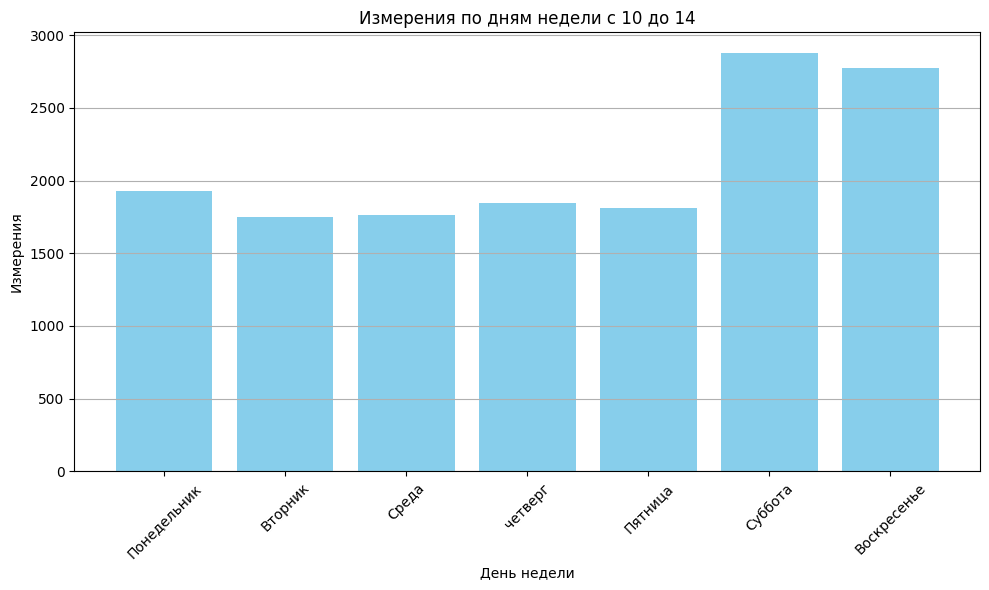

In [33]:
plt.figure(figsize=(10, 6))
plt.bar(days_of_week, num_of_trips, color="skyblue")
plt.title("Измерения по дням недели с 10 до 14")
plt.xlabel("День недели")
plt.ylabel("Измерения")
plt.xticks(rotation=45)
plt.grid(axis="y")

plt.tight_layout()
plt.show()

<i> С 14 до 18 </i>

In [34]:
#измерение поездок по дням недели
num_of_trips = []
days_of_week = ["Понедельник", "Вторник", "Среда", "четверг", "Пятница", "Суббота", "Воскресенье"]
promo_days = df_merged[(df_merged["start_date"].dt.weekday == 0) & (df_merged["start_date"].dt.hour >= 14) & (df_merged["start_date"].dt.hour < 18)]
num_of_trips.append(promo_days.shape[0])
for i in range(1,7):
    non = df_merged[(df_merged["start_date"].dt.weekday == i) & (df_merged["start_date"].dt.hour >= 14) & (df_merged["start_date"].dt.hour < 18)]
    num_of_trips.append(non.shape[0])

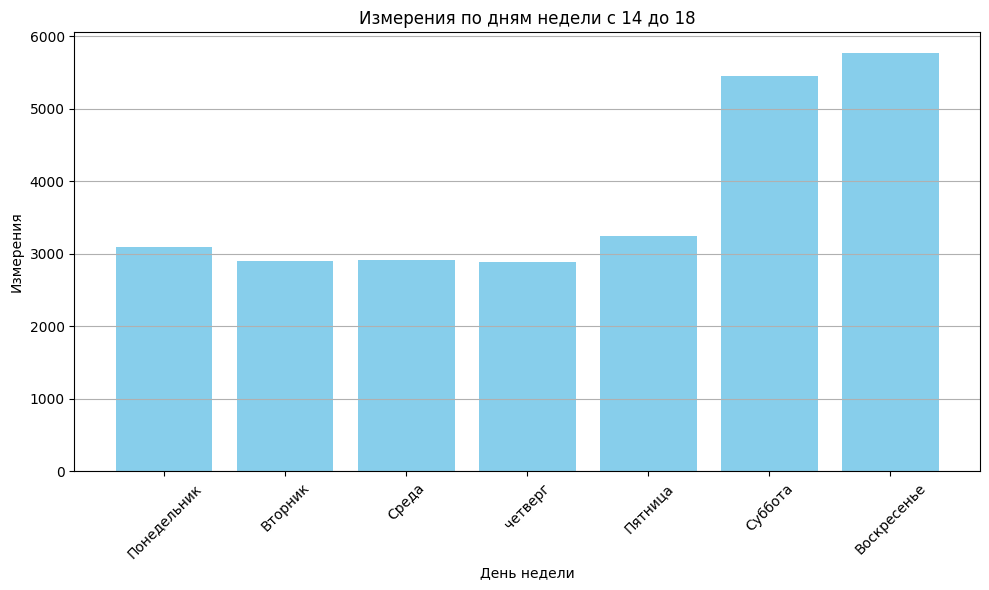

In [35]:
plt.figure(figsize=(10, 6))
plt.bar(days_of_week, num_of_trips, color="skyblue")
plt.title("Измерения по дням недели с 14 до 18")
plt.xlabel("День недели")
plt.ylabel("Измерения")
plt.xticks(rotation=45)
plt.grid(axis="y")

plt.tight_layout()
plt.show()

<i>Вывод: видно, что в понедельник во время акции спрос выше, сравнивая с другими периодами по дням недели. </i>

<i>Проверим количество поездок с использованием акции в понедельник с 6 до 10</i>

In [36]:
promo_start = df_merged[(df_merged["start_date"].dt.weekday == 0) & (df_merged["start_date"].dt.hour >= 6) & (df_merged["start_date"].dt.hour < 10) & (df_merged["promo"] == True)]
ordinary_start = df_merged[(df_merged["start_date"].dt.weekday == 0) & (df_merged["start_date"].dt.hour >= 6) & (df_merged["start_date"].dt.hour < 10) & (df_merged["promo"] == False)]

print(promo_start.shape[0], ordinary_start.shape[0])

1911 764


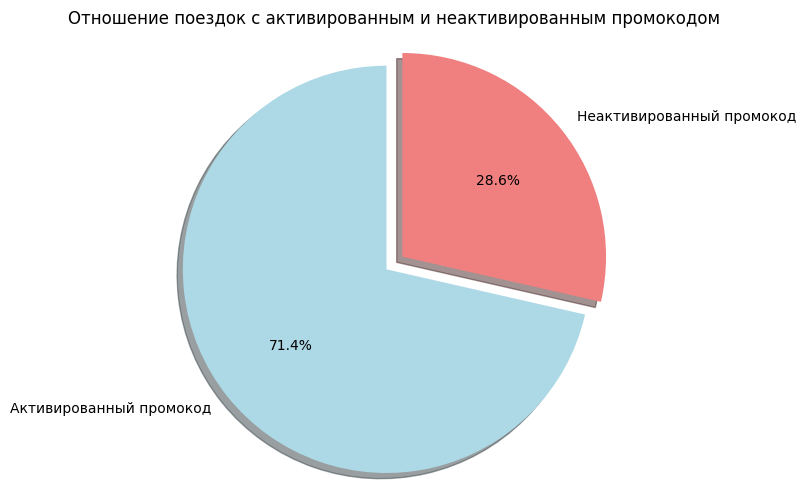

In [37]:
activated = promo_start.shape[0]
not_activated = ordinary_start.shape[0]
labels = ["Активированный промокод", "Неактивированный промокод"]
sizes = [activated, not_activated]
colors = ["lightblue", "lightcoral"]
explode = (0.1, 0)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct="%1.1f%%",
        shadow=True, startangle=90)

plt.axis("equal")
plt.title("Отношение поездок с активированным и неактивированным промокодом")
plt.show()

<h5>Вывод: </h5>

<i>Акция стимулирует спрос, так как в день акции количество поездок больше, чем в другие дни, а также большая часть из них совершается с применением промокода. </i>

Проверка окпуаемости акции

In [38]:
cost_promo = promo_start.shape[0] * 30 #стоимость бесплатных стартов
reven_promo = promo_start["fare"].sum() #прибыль с поездок 
print("Прибыль от поездок в понедельники с 6:00 до 10:00:", reven_promo)
print("Издержки на проведение акции:", cost_promo)


Прибыль от поездок в понедельники с 6:00 до 10:00: 197395.175
Издержки на проведение акции: 57330


<h5>Вывод: </h5>

<i>Акция генерирует дополнительный спрос, а также прибыль от поездок больше издержек, следовательно, акция выгодна для компании.</i>

In [39]:
df_merged.head(3)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,start_hour,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration,duration,fare
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,23.700000,124.800000
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,28.416667,143.666667
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,38.316667,183.266667


<h4> 3) Иследование корреляций между параметрами погодных условий. </h4>

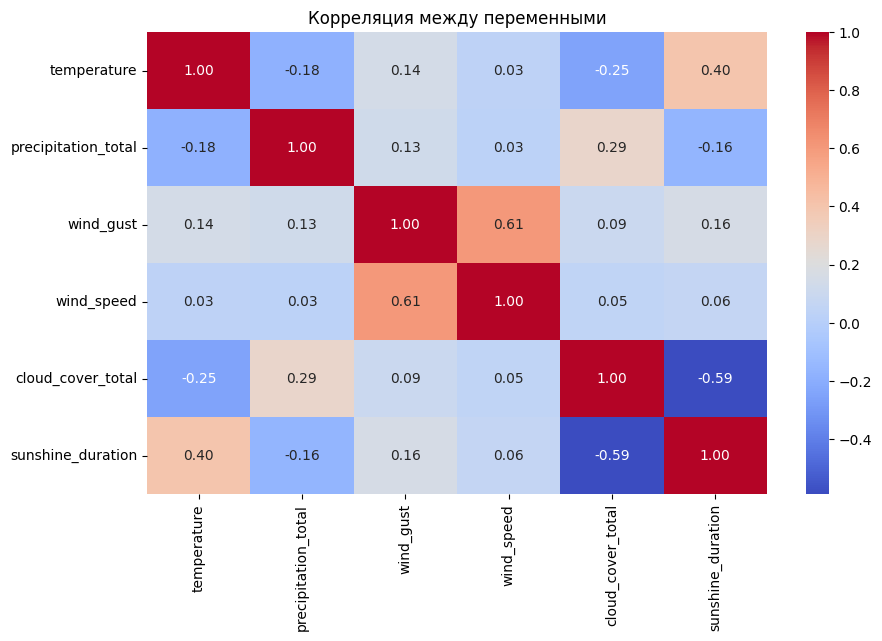

In [40]:
weather_corr = df_merged[["temperature", "precipitation_total", "wind_gust", "wind_speed", "cloud_cover_total", "sunshine_duration"]].corr(method="kendall")
plt.figure(figsize=(10, 6))
sns.heatmap(weather_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляция между переменными")
plt.show()


<h5>Выводы:</h5>

* <i>Корреляция между "wind_gust" и "wind_speed" обоснована, так как порывы ветра и средняя скорость ветра тесно связаны. </i>
* <i>Корреляция между "cloud_cover_total" и "sunshine_duration" обоснована, так как облачность и продолжительность солнечного сияния обратно пропорциональны. </i>

<h4> 4) Почасовой трафик в каждой точке </h4>

<i>Агрегация по часам </i>

In [41]:
hourly_traffic = df_merged.resample("H", on="start_date").agg({"id": "count"})
hourly_traffic.rename(columns={"id": "traffic"}, inplace=True)
print(hourly_traffic)


                     traffic
start_date                  
2023-04-22 09:00:00       20
2023-04-22 10:00:00       42
2023-04-22 11:00:00       29
2023-04-22 12:00:00       46
2023-04-22 13:00:00       47
...                      ...
2023-07-31 19:00:00      113
2023-07-31 20:00:00       73
2023-07-31 21:00:00       81
2023-07-31 22:00:00       27
2023-07-31 23:00:00       19

[2415 rows x 1 columns]


<i>Агрегация по времени и сумме стартов и конца поездок на каждой точке в момент</i>

In [42]:
df_merged_1 = df_merged.copy(deep=True)
df_merged_1.set_index("start_date", inplace=True)
# Агрегируем количество стартов по часам и по местоположениям
traffic_start = df_merged_1.groupby([pd.Grouper(freq="H"), "start_location"]).size().reset_index(name="trips_started")

# Агрегируем количество финишей по часам и по местоположениям
traffic_end = df_merged_1.groupby([pd.Grouper(freq="H"), "end_location"]).size().reset_index(name="trips_finished")

# Переименовываем столбцы для объединения
traffic_start.rename(columns={"start_location": "location"}, inplace=True)
traffic_end.rename(columns={"end_location": "location"}, inplace=True)

# Объединяем данные о стартах и финишах
traffic_hourly = pd.merge(traffic_start, traffic_end, on=["start_date", "location"], how="outer")

traffic_hourly.fillna(0, inplace=True)

# Суммируем старты и финиши для каждой локации в каждой временной метке
traffic_hourly["total_trips"] = traffic_hourly["trips_started"] + traffic_hourly["trips_finished"]

traffic_hourly_sorted = traffic_hourly.sort_values(by="total_trips", ascending=False)

print(traffic_hourly)


                start_date   location  trips_started  trips_finished  \
0      2023-04-22 09:00:00  буденного            2.0             0.0   
1      2023-04-22 09:00:00  восточная            1.0             0.0   
2      2023-04-22 09:00:00   западная            1.0             2.0   
3      2023-04-22 09:00:00    зеленая            1.0             0.0   
4      2023-04-22 09:00:00   комарова            1.0             0.0   
...                    ...        ...            ...             ...   
106775 2023-07-31 23:00:00  совхозная            0.0             1.0   
106776 2023-07-31 23:00:00   суворова            0.0             1.0   
106777 2023-07-31 23:00:00    чапаева            0.0             1.0   
106778 2023-07-31 23:00:00    чкалова            0.0             1.0   
106779 2023-07-31 23:00:00   шевченко            0.0             1.0   

        total_trips  
0               2.0  
1               1.0  
2               3.0  
3               1.0  
4               1.0  
...

<h4> 5) Топ-3 точки с самым высоким трафиком. </h4>

In [43]:
traffic_start = df_merged_1.groupby("start_location").size().reset_index(name="trips_started")
traffic_end = df_merged_1.groupby("end_location").size().reset_index(name="trips_finished")

# Объединяем данные о стартах и финишах
traffic_combined = pd.merge(traffic_start, traffic_end, left_on="start_location", right_on="end_location", how="outer").fillna(0)

#перевод в целочисленный тип данных
traffic_combined["trips_started"] = traffic_combined["trips_started"].astype(int)
traffic_combined["trips_finished"] = traffic_combined["trips_finished"].astype(int)
traffic_combined["total_traffic"] = (traffic_combined["trips_started"] + traffic_combined["trips_finished"]).astype(int)



#Рейтинг стартов
traffic_combined_sorted_start = traffic_combined[["start_location", "trips_started"]].sort_values(by="trips_started", ascending=False)
traffic_combined_sorted_start.reset_index(drop=True, inplace=True)
traffic_combined_sorted_start.rename(columns={"start_location": "location"}, inplace=True)

#Рейтинг финишов
traffic_combined_sorted_end = traffic_combined[["start_location", "trips_finished"]].sort_values(by="trips_finished", ascending=False)
traffic_combined_sorted_end.reset_index(drop=True, inplace=True)
traffic_combined_sorted_end.rename(columns={"start_location": "location"}, inplace=True)

# Считаем общий трафик
traffic_combined["total_traffic"] = traffic_combined["trips_started"] + traffic_combined["trips_finished"]
traffic_combined_sorted_total = traffic_combined[["start_location", "total_traffic"]].sort_values(by="total_traffic", ascending=False)
traffic_combined_sorted_total.reset_index(drop=True, inplace=True)
traffic_combined_sorted_total.rename(columns={"start_location": "location"}, inplace=True)


In [44]:
print("Топ-3 точек с самым высоким трафиком (начало поездки):")
print(traffic_combined_sorted_start[:3])


print("\nТоп-3 точек с самым высоким трафиком (конец поездки):")
print(traffic_combined_sorted_end[:3])


print("\nТоп-3 точек по общему трафику::")
print(traffic_combined_sorted_total[:3])



Топ-3 точек с самым высоким трафиком (начало поездки):
     location  trips_started
0     луговая           2293
1  ломоносова           2293
2     майская           2238

Топ-3 точек с самым высоким трафиком (конец поездки):
     location  trips_finished
0  спортивная            2314
1   восточная            2288
2   буденного            2281

Топ-3 точек по общему трафику::
     location  total_traffic
0     луговая           4562
1  ломоносова           4539
2  спортивная           4507


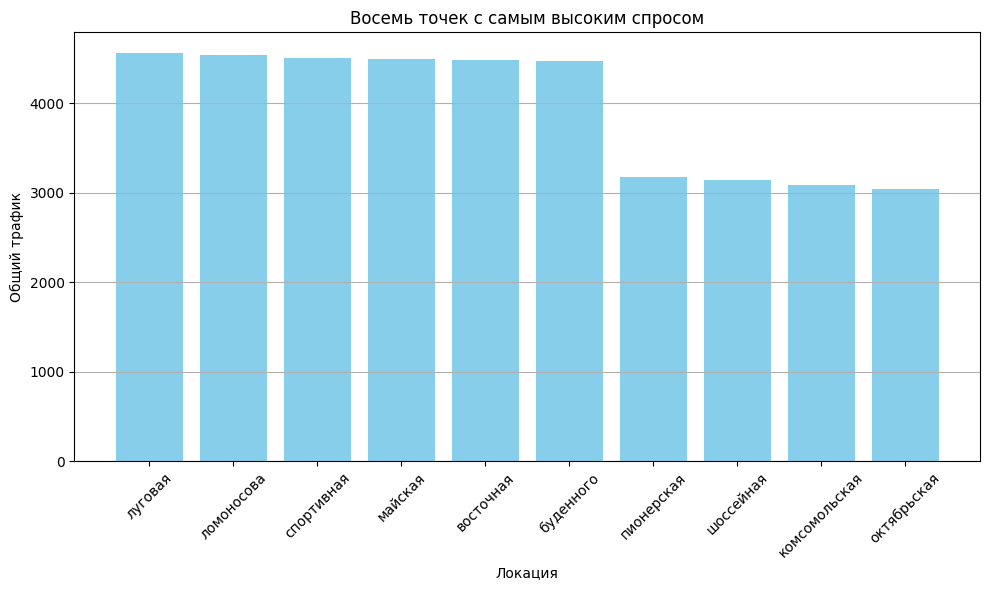

In [45]:
top_10 = traffic_combined_sorted_total.nlargest(10, "total_traffic")

# Построение графика
plt.figure(figsize=(10, 6))
plt.bar(top_10["location"], top_10["total_traffic"], color="skyblue")
plt.title("Восемь точек с самым высоким спросом")
plt.xlabel("Локация")
plt.ylabel("Общий трафик")
plt.xticks(rotation=45)
plt.grid(axis="y")

# Показать график
plt.tight_layout()
plt.show()

In [46]:
df_merged.head(5)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,start_hour,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration,duration,fare
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,23.700000,124.800000
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,28.416667,143.666667
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,38.316667,183.266667
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,31.816667,157.266667
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,9,2023-04-22 09:00:00,13.850245,0.0,20.16,6.214563,71.0,16.969696,30.666667,152.666667


<i> Предположим, что можем закрыть 3 точки на которых трафик меньше всего </i>

In [47]:
traffic_combined_sorted_total[::-1][:3]

,location,total_traffic
90,пушкина,1540
89,набережная,1567
88,степная,1600


<i> Самые популярные направления перемещений </i>

In [48]:
popular_routes = df_merged.groupby(["start_location", "end_location"]).size().reset_index(name="count")
popular_routes = popular_routes.nlargest(5, "count")
print("Самые популярные направления перемещения:\n", popular_routes)

Самые популярные направления перемещения:
      start_location end_location  count
184       буденного    буденного     68
3256        луговая   спортивная     67
3347        майская   спортивная     61
6586     спортивная      майская     60
489       восточная   ломоносова     59


<i>Есть необходимость перемещать самокаты из точек с наименьшим трафиком в точки с наибольшим, если количество самокатов на момент начала дня не будет удолитворять спрос</i>

<h4> 6) Накопительное поведение в точках </h4>

In [49]:
# Считаем разницу между стартами и финишами
traffic_combined["difference"] = traffic_combined["trips_started"].astype(int) - traffic_combined["trips_finished"].astype(int)

# Вычисляем накопительную сумму разницы
traffic_combined["cumulative_difference"] = traffic_combined["difference"].cumsum()

# Определяем необходимое количество самокатов
# Предположим, что каждый самокат может обслуживать 1 поездку в час и перераспределяется ежедневно в 6:00
hours_per_day = 24  

# Необходимое количество самокатов для удовлетворения спроса
traffic_combined["required_scooters"] = np.ceil(traffic_combined["cumulative_difference"] / hours_per_day).clip(lower=0)

# Печатаем результаты
print(traffic_combined[["start_location", "trips_started", "trips_finished", "required_scooters"]])

   start_location  trips_started  trips_finished  required_scooters
0       береговая            874             833                2.0
1       березовая           1228            1222                2.0
2       буденного           2185            2281                0.0
3        вишневая            834             893                0.0
4      вокзальная            826             898                0.0
..            ...            ...             ...                ...
86      шоссейная           1560            1585                3.0
87    энергетиков            833             855                2.0
88    энтузиастов            795             839               -0.0
89      юбилейная            831             863                0.0
90          южная            850             811                0.0

[91 rows x 4 columns]


In [50]:

traffic_cumsum = df_merged.groupby(["start_location", "start_hour"]).size().groupby(level=0).cumsum()
print(traffic_cumsum)
trips_by_hour_location_district = df_merged.groupby(["start_hour", "start_location", "start_district"]).size()
print(trips_by_hour_location_district)


start_location  start_hour
береговая       0              11
                1              18
                2              22
                3              24
                4              28
                             ... 
южная           19            623
                20            708
                21            779
                22            823
                23            850
Length: 2161, dtype: int64
start_hour  start_location  start_district 
0           береговая       центральный        11
            березовая       северо-западный    12
            буденного       октябрьский        28
            вишневая        юго-восточный       7
            вокзальная      юго-восточный      13
                                               ..
23          шоссейная       заречный           50
            энергетиков     юго-восточный      19
            энтузиастов     центральный        21
            юбилейная       юго-восточный      24
            южная           

<h2>Проверка гипотез</h2>

<h4>1. Верно ли, что в дождливое время спрос на самокаты ниже?<h4>

In [51]:
df_merged["is_rainy"] = df_merged["precipitation_total"] > 0

# Группировка данных
rainy_count = df_merged[df_merged["is_rainy"]].shape[0]
dry_count = df_merged[~df_merged["is_rainy"]].shape[0]

# Создаем датафрейм для удобства
summary_df = pd.DataFrame({
    "Weather": ["Rainy", "Dry"],
    "Count": [rainy_count, dry_count]
})

print(summary_df)

# Статистический тест
# Создаем таблицу сопряженности
contingency_table = [[rainy_count, dry_count]]


# Применяем тест хи-квадрат
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-squared: {chi2}, p-value: {p}")

# Интерпретация результата
alpha = 0.05
if p < alpha:
    print("Отвергаем нулевую гипотезу: существует значительная разница в спросе на самокаты в дождливую и сухую погоду.")
else:
    print("Не хватает доказательств для отклонения нулевой гипотезы: спрос на самокаты не отличается в дождливую и сухую погоду.")


  Weather  Count
0   Rainy  14804
1     Dry  82568
Chi-squared: 0.0, p-value: 1.0
Не хватает доказательств для отклонения нулевой гипотезы: спрос на самокаты не отличается в дождливую и сухую погоду.


<h4>2. Отличается ли средняя стоимость поездки по районам?</h4>

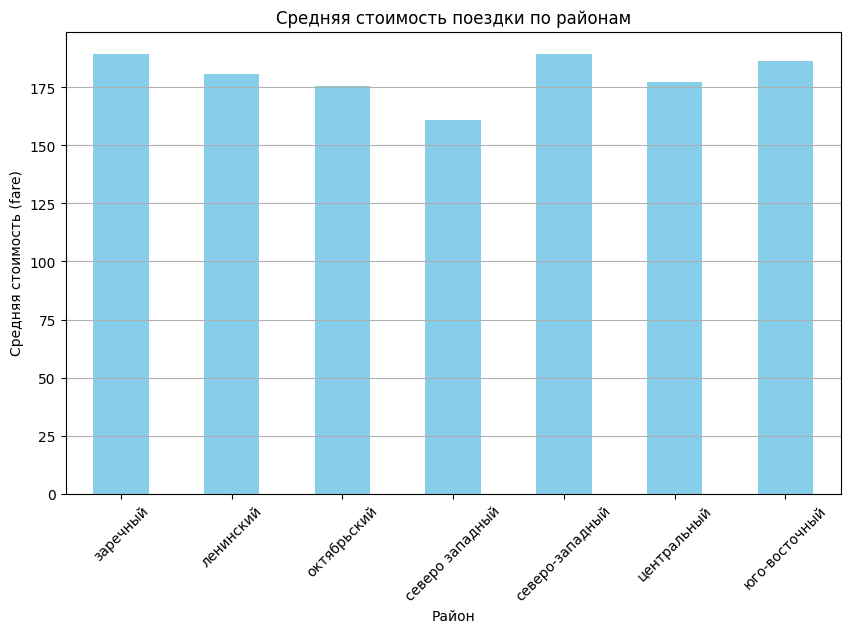

F-статистика: 107.72089346418369, P-значение: 6.773078131217671e-136
Существует статистически значимая разница в средней стоимости поездки по районам.


In [52]:
mean_fare_by_district = df_merged.groupby("start_district")["fare"].mean()

# Визуализируем результаты
plt.figure(figsize=(10, 6))
mean_fare_by_district.plot(kind="bar", color="skyblue")
plt.title("Средняя стоимость поездки по районам")
plt.xlabel("Район")
plt.ylabel("Средняя стоимость (fare)")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.xticks(rotation=45)
plt.show()

districts = df_merged["start_district"].unique()

anova_data = [df_merged[df_merged["start_district"] == district]["fare"] for district in districts]

# Проведение ANOVA-теста для проверки различий между группами
anova_result = stats.f_oneway(*anova_data)

print(f"F-статистика: {anova_result.statistic}, P-значение: {anova_result.pvalue}")

# Интерпретация результатов ANOVA
if anova_result.pvalue < 0.05:
    print("Существует статистически значимая разница в средней стоимости поездки по районам.")
else:
    print("Нет статистически значимой разницы в средней стоимости поездки по районам.")

<h4>3. Верно ли, что спрос на самокаты меняется в зависимости от дня недели?</h4>

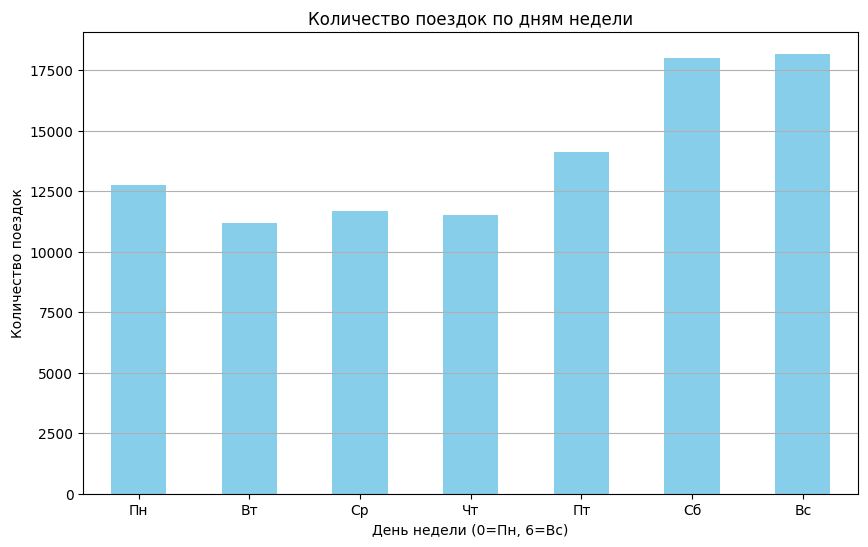

F-статистика: 72.30593407712314, P-значение: 2.370195029150351e-90
Существует статистически значимая разница в спросе на самокаты в разные дни недели.


In [53]:
#День недели
df_merged["day_of_week"] = df_merged["start_date"].dt.dayofweek
#Кол-во поездок по дням недели
trip_counts = df_merged["day_of_week"].value_counts().sort_index()

# Визуализация данных
plt.figure(figsize=(10, 6))
trip_counts.plot(kind="bar", color="skyblue")
plt.title("Количество поездок по дням недели")
plt.xlabel("День недели (0=Пн, 6=Вс)")
plt.ylabel("Количество поездок")
plt.xticks(ticks=range(7), labels=["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"], rotation=0)
plt.grid(axis="y")
plt.show()

# Проведение ANOVA-теста для проверки различий между группами
anova_result = stats.f_oneway(
    df_merged[df_merged["day_of_week"] == 0]["distance"],  # Понедельник
    df_merged[df_merged["day_of_week"] == 1]["distance"],  # Вторник
    df_merged[df_merged["day_of_week"] == 2]["distance"],  # Среда
    df_merged[df_merged["day_of_week"] == 3]["distance"],  # Четверг
    df_merged[df_merged["day_of_week"] == 4]["distance"],  # Пятница
    df_merged[df_merged["day_of_week"] == 5]["distance"],  # Суббота
    df_merged[df_merged["day_of_week"] == 6]["distance"]   # Воскресенье
)

print(f"F-статистика: {anova_result.statistic}, P-значение: {anova_result.pvalue}")

# Интерпретация результатов ANOVA
if anova_result.pvalue < 0.05:
    print("Существует статистически значимая разница в спросе на самокаты в разные дни недели.")
else:
    print("Нет статистически значимой разницы в спросе на самокаты в разные дни недели.")

<h4>4. Верно ли, что в выходные дни поездки более длительные?</h4>

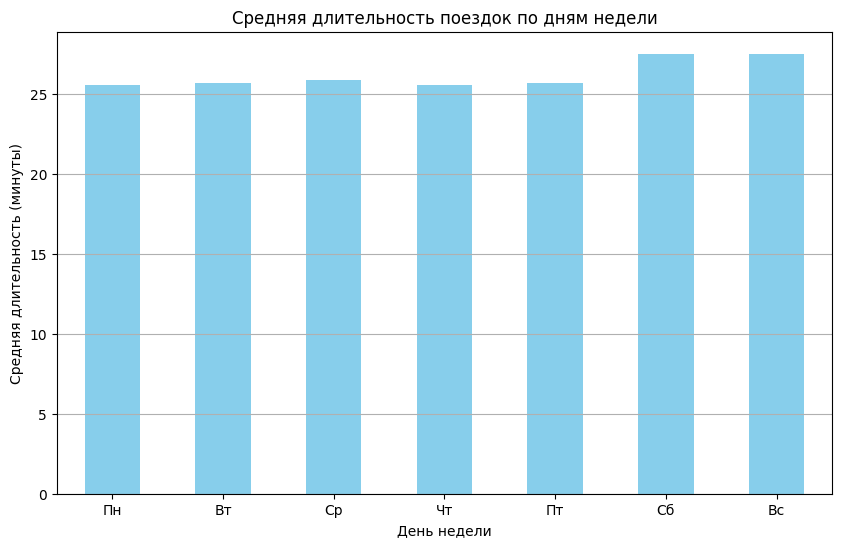

T-статистика: -28.031881431580402, P-значение: 3.228213101952677e-172
Существует статистически значимая разница в длительности поездок между будними и выходными днями.


In [54]:
#Длительность поездок в минутах
df_merged["duration"] = (df_merged["end_date"] - df_merged["start_date"]).dt.total_seconds() / 60
#Делим на будние и выходные
df_merged["is_weekend"] = df_merged["day_of_week"] >= 5 

weekdays_duration = df_merged[df_merged["is_weekend"] == False]["duration"]
weekend_duration = df_merged[df_merged["is_weekend"] == True]["duration"]

# Группировка данных по дням недели и расчет средней длительности
mean_duration_by_day = df_merged.groupby("day_of_week")["duration"].mean()

# Визуализация результатов
plt.figure(figsize=(10, 6))
mean_duration_by_day.plot(kind="bar", color="skyblue")
plt.title("Средняя длительность поездок по дням недели")
plt.xlabel("День недели")
plt.xticks(ticks=range(7), labels=["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"], rotation=0)
plt.ylabel("Средняя длительность (минуты)")
plt.grid(axis="y")
plt.show()

# Проведение t-теста
t_stat, p_value = stats.ttest_ind(weekdays_duration, weekend_duration)

print(f"T-статистика: {t_stat}, P-значение: {p_value}")

# Интерпретация результатов
if p_value < 0.05:
    print("Существует статистически значимая разница в длительности поездок между будними и выходными днями.")
else:
    print("Нет статистически значимой разницы в длительности поездок между будними и выходными днями.")

<h4>5. Верно ли, что в будние дни поездки более скоростные?</h4>

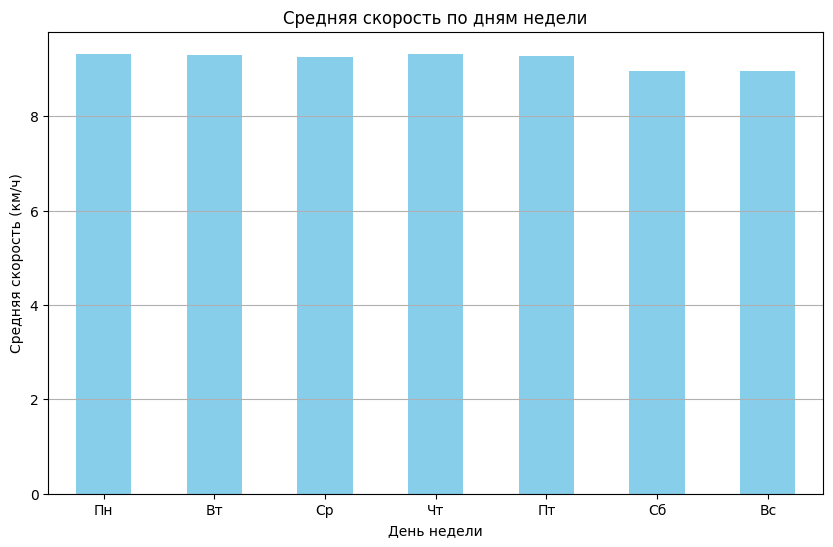

T-статистика: 22.155084918664766, P-значение: 1.730567408739518e-108
Существует статистически значимая разница в скорости между будними и выходными днями.


In [55]:
df_merged["speed"] = df_merged["distance"] / df_merged["duration"]
weekdays_speed = df_merged[df_merged["is_weekend"] == False]["speed"]
weekend_speed = df_merged[df_merged["is_weekend"] == True]["speed"]

t_stat, p_value = stats.ttest_ind(weekdays_speed, weekend_speed)

# для удобства интерпретации данных на графике переведём скорость из м/мин в км/ч
df_merged["speed_km"] = (df_merged["distance"] / 1000) / (df_merged["duration"] /60)
speed_of_week_km = df_merged.groupby("day_of_week")["speed_km"].mean()
plt.figure(figsize=(10, 6))
speed_of_week_km.plot(kind="bar", color="skyblue")
plt.title("Средняя скорость по дням недели")
plt.xlabel("День недели")
plt.xticks(ticks=range(7), labels=["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"], rotation=0)
plt.ylabel("Средняя скорость (км/ч)")
plt.grid(axis="y")
plt.show()

print(f"T-статистика: {t_stat}, P-значение: {p_value}")

# Интерпретация результатов
if p_value < 0.05:
    print("Существует статистически значимая разница в скорости между будними и выходными днями.")
else:
    print("Нет статистически значимой разницы в скорости между будними и выходными днями.")

<h2>Регрессионное моделирование</h2>

In [56]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler



In [57]:
df_merged.head(5)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,start_hour,...,wind_speed,cloud_cover_total,sunshine_duration,duration,fare,is_rainy,day_of_week,is_weekend,speed,speed_km
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,9,...,6.214563,71.0,16.969696,23.700000,124.800000,False,5,True,171.687764,10.301266
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,9,...,6.214563,71.0,16.969696,28.416667,143.666667,False,5,True,158.885630,9.533138
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,9,...,6.214563,71.0,16.969696,38.316667,183.266667,False,5,True,117.964332,7.077860
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,9,...,6.214563,71.0,16.969696,31.816667,157.266667,False,5,True,121.980094,7.318806
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,9,...,6.214563,71.0,16.969696,30.666667,152.666667,False,5,True,131.380435,7.882826


In [58]:
# Ресемплим данные по часу и считаем количество стартов
demand_per_hour = df_merged.resample("H", on="start_date").size().reset_index(name="demand")

# Добавляем данные о погоде
weather_data = df_merged[["datetime", "temperature", "precipitation_total", "wind_speed", "wind_gust", "cloud_cover_total", 
                            "sunshine_duration"]].drop_duplicates().set_index("datetime")
demand_weather = demand_per_hour.merge(weather_data, left_on="start_date", right_index=True, how="left")

# Извлекаем час и день недели
demand_weather["hour"] = demand_weather["start_date"].dt.hour
demand_weather["day_of_week"] = demand_weather["start_date"].dt.dayofweek

# Условие для применения промокода (по понедельникам с 6 до 10)
demand_weather["promo_code"] = np.where((demand_weather["day_of_week"] == 0) & 
                                         (demand_weather["hour"] >= 6) & 
                                         (demand_weather["hour"] < 10), 1, 0)

# Создаем лаги спроса
demand_weather["demand_lag_1"] = demand_weather["demand"].shift(1)
demand_weather["demand_lag_24"] = demand_weather["demand"].shift(24)

# Удаляем NaN
demand_weather.dropna(inplace=True)

# Делим данные на трейн и тест 
X = demand_weather.drop(columns=["demand", "start_date"])
y = demand_weather["demand"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45, shuffle=True)

# Кодируем категориальные признаки
encoder = OneHotEncoder(drop="first", sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train[["hour", "day_of_week", "promo_code"]])
X_test_encoded = encoder.transform(X_test[["hour", "day_of_week", "promo_code"]])

# Объединяем закодированные признаки с остальными признаками
X_train_final = np.hstack((X_train.drop(columns=["hour", "day_of_week", "promo_code"]).values, X_train_encoded))
X_test_final = np.hstack((X_test.drop(columns=["hour", "day_of_week", "promo_code"]).values, X_test_encoded))

# Обучаем модель
model = LinearRegression()
model.fit(X_train_final, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test_final)

# Метрики качества
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 136.99259278124754
R^2 Score: 0.8539157091627751


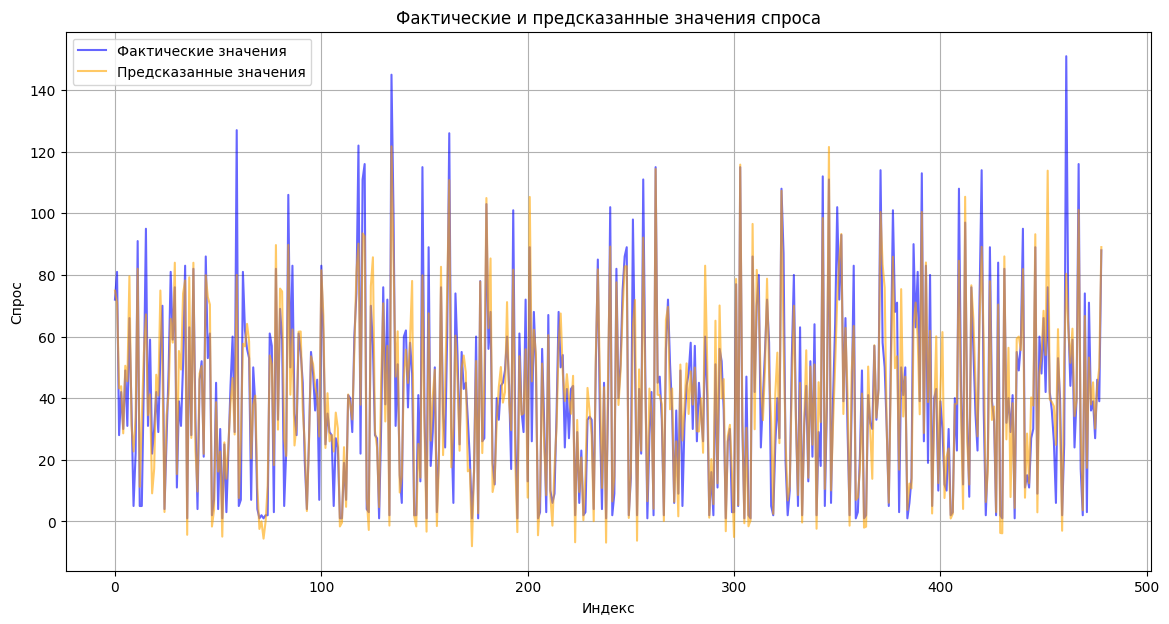

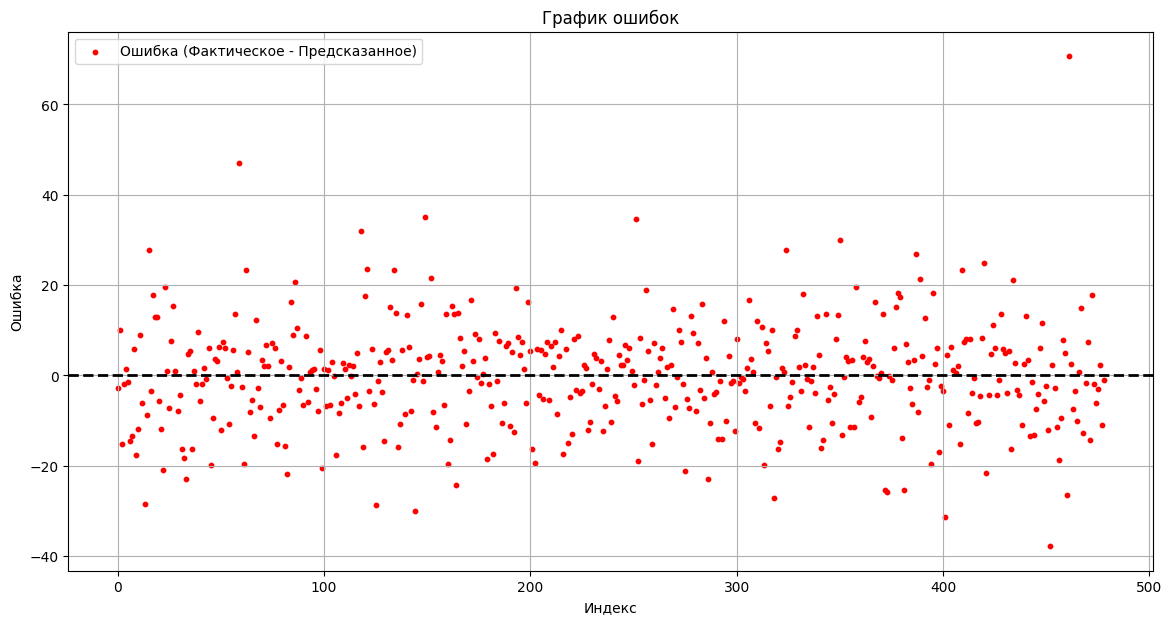

In [67]:

#DataFrame для фактических и предсказанных значений
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Индексы для графиков
results.reset_index(drop=True, inplace=True)

# График фактических и предсказанных значений
plt.figure(figsize=(14, 7))
plt.plot(results['Actual'], label='Фактические значения', color='blue', alpha=0.6)
plt.plot(results['Predicted'], label='Предсказанные значения', color='orange', alpha=0.6)
plt.title('Фактические и предсказанные значения спроса')
plt.xlabel('Индекс')
plt.ylabel('Спрос')
plt.legend()
plt.grid()
plt.show()

# График ошибок
errors = results['Actual'] - results['Predicted']
plt.figure(figsize=(14, 7))
plt.scatter(results.index, errors, label='Ошибка (Фактическое - Предсказанное)', color='red', s=10)
plt.axhline(0, color='black', lw=2, ls='--')
plt.title('График ошибок')
plt.xlabel('Индекс')
plt.ylabel('Ошибка')
plt.legend()
plt.grid()
plt.show()

<h5>Выводы:</h5>

* <i>MSE = 136.99 — означает квадрат ошибки в среднем для реального и предсказуемого значения</i>
* <i>R² = 0.85 — коэффициент детерминации более 0,75, поэтому модель подходит.</i>